# Подготовка окружения

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import AutoTokenizer, pipeline
from torch.utils.data import DataLoader, RandomSampler
from torch.serialization import add_safe_globals
from configs.config import Config
from src.data_utils import process_dataset, split_dataset
from src.next_token_dataset import TextDataset
from src.lstm_model import LSTMModel, count_parameters, generate_samples
from src.lstm_train import train_model
from src.eval_lstm import calculate_rouge_lstm
from src.eval_transformer_pipeline import calculate_rouge_transformer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
IS_TEST = True # тестовый сценарий для отладки кода на слабой машине
config = Config(is_test=IS_TEST) # конфигурационные параметры

tokenizer = AutoTokenizer.from_pretrained(config.tokenizer_name)
tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token

config.pad_token_id = tokenizer.pad_token_id or tokenizer.eos_token_id
config.pad_token = tokenizer.pad_token
config.vocab_size = len(tokenizer)

print(f'вычисления на {config.device}\n')
print('\n параметры запуска')
vars(config)

вычисления на cuda


 параметры запуска


{'raw_ds_path': './data/raw_dataset.txt',
 'ds_processed_path': './data/dataset_processed.txt',
 'ds_train_path': './data/train.csv',
 'ds_val_path': './data/val.csv',
 'ds_test_path': './data/test.csv',
 'model_path': './models/lstm_model.pth',
 'max_raw__ds_length': 1000,
 'batch_size': 16,
 'embedding_dim': 256,
 'hidden_dim': 128,
 'num_layers': 1,
 'dropout': 0.2,
 'learning_rate': 0.002,
 'num_epochs': 10,
 'max_length': 50,
 'train_val_split': 0.8,
 'val_rouge_samples': 200,
 'text_split_on_prediction': 0.75,
 'device': 'cuda',
 'tokenizer_name': 'distilgpt2',
 'pad_token_id': 50256,
 'pad_token': '<|endoftext|>',
 'vocab_size': 50257}

# Подготовка датасета

### 1. Получение и очистка исходных текстов

In [3]:
file = config.raw_ds_path
if not os.path.exists(file):
    !wget https://code.s3.yandex.net/deep-learning/tweets.txt -O {file}


количество текстов: 977

статистика количества слов в тексте:
         мин: 2
     медиана: 12.00
     среднее: 13.12
        макс: 31
 5-й перц-ль: 4.00
95-й перц-ль: 25.00


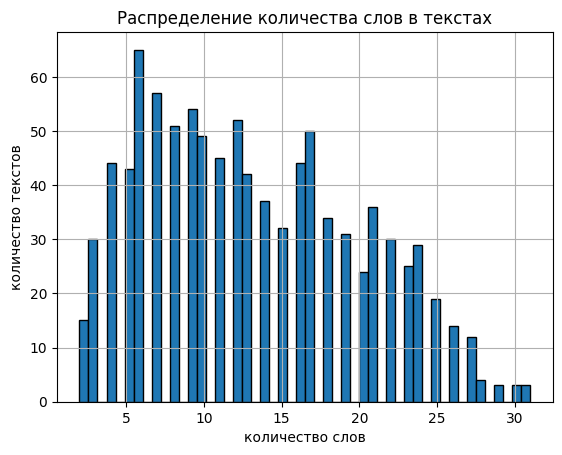


примеры чистых текстов:

www that s a bummer ou shoulda got avid arr of hird ay to do it
is upset that he can t update his acebook by texting it and might cry as a result chool today also lah
dived many times for the ball anaged to save 50 he rest go out of bounds
my whole body feels itchy and like its on fire
no it s not behaving at all i m mad why am i here because can t see you all over there


In [4]:
clean_corpus = process_dataset(config)

### 2. Разделение датасета на подсеты с сохранением в файлы 

In [5]:
train_texts, val_texts, test_texts = split_dataset(texts=clean_corpus,config=config)

# Подготовка Dataloaders

### 1. Инициализация Datasets

In [6]:
train_dataset = TextDataset(train_texts, tokenizer, config)
val_dataset = TextDataset(val_texts, tokenizer, config)
test_dataset = TextDataset(test_texts, tokenizer, config)

print(f'\ntrain_dataset len:', f"{len(train_dataset):_}")
print(f'val_dataset len:  ', f"{len(val_dataset):_}")
print(f'test_dataset len: ', f"{len(test_dataset):_}")


train_dataset len: 781
val_dataset len:   98
test_dataset len:  98


### 2. Инициализация Dataloaders

In [7]:
dl_config = {
    'batch_size': config.batch_size,
    'num_workers': 4,
    'pin_memory': config.device=='cuda',
    'persistent_workers': True,
    'prefetch_factor': 2,
}

# подвыборка валидационного сета для расчета rouge на эпохах обучения
val_sampler = RandomSampler(
    val_dataset, 
    replacement=False, 
    num_samples=config.val_rouge_samples   
)

train_dataloader = DataLoader(train_dataset, **dl_config, shuffle=True)
val_dataloader = DataLoader(val_dataset, **dl_config, shuffle=False)
val_sample_dataloader = DataLoader(val_dataset, **dl_config, shuffle=False, sampler=val_sampler)
test_dataloader = DataLoader(test_dataset, **dl_config, shuffle=False)

print(f'батчей в train:    {len(train_dataloader)}')
print(f'батчей в val:      {len(val_dataloader)}')
print(f'батчей в val_smpl: {len(val_sample_dataloader)}')
print(f'батчей в test:     {len(test_dataloader)}')

батчей в train:    49
батчей в val:      7
батчей в val_smpl: 13
батчей в test:     7


# Обучение модели

### Инициализация модели

In [8]:
model = LSTMModel(config)
print('количество параметров: ', f'{count_parameters(model):_}')
model = model.to(config.device)

количество параметров:  19_546_577


In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=config.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

### Обучение и валидация

Модель на cuda:0



         сalc rouge metrics val_smpl: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s, rouge1 max=0.1333]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.45 GB (3.1%)
reserved mem : 0.54 GB
max per epoch: 0.83 GB
=====>GPU 0]

  train loss:      9.3156, val loss: 7.7797
  val_smpl rouge1: 0.0199,   val_smpl rouge2: 0.0000

 -------------------- end of epoch 1/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s, rouge1 max=0.1714]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.45 GB (3.1%)
reserved mem : 0.54 GB
max per epoch: 0.84 GB
=====>GPU 0]

  train loss:      7.0343, val loss: 7.4296
  val_smpl rouge1: 0.0245,   val_smpl rouge2: 0.0003

 -------------------- end of epoch 2/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s, rouge1 max=0.1875]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.45 GB (3.1%)
reserved mem : 0.54 GB
max per epoch: 0.84 GB
=====>GPU 0]

  train loss:      6.5573, val loss: 7.3639
  val_smpl rouge1: 0.0204,   val_smpl rouge2: 0.0000

 -------------------- end of epoch 3/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s, rouge1 max=0.1818]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.45 GB (3.1%)
reserved mem : 0.54 GB
max per epoch: 0.84 GB
=====>GPU 0]

  train loss:      6.2453, val loss: 7.3537
  val_smpl rouge1: 0.0218,   val_smpl rouge2: 0.0000

 -------------------- end of epoch 4/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s, rouge1 max=0.1765]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.45 GB (3.1%)
reserved mem : 0.54 GB
max per epoch: 0.84 GB
=====>GPU 0]

  train loss:      5.9598, val loss: 7.3431
  val_smpl rouge1: 0.0204,   val_smpl rouge2: 0.0000

 -------------------- end of epoch 5/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s, rouge1 max=0.1290]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.45 GB (3.1%)
reserved mem : 0.54 GB
max per epoch: 0.84 GB
=====>GPU 0]

  train loss:      5.6850, val loss: 7.3609
  val_smpl rouge1: 0.0210,   val_smpl rouge2: 0.0003

 -------------------- end of epoch 6/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s, rouge1 max=0.1935]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.45 GB (3.1%)
reserved mem : 0.54 GB
max per epoch: 0.84 GB
=====>GPU 0]

  train loss:      5.4084, val loss: 7.3748
  val_smpl rouge1: 0.0190,   val_smpl rouge2: 0.0006

 -------------------- end of epoch 7/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s, rouge1 max=0.1818]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.45 GB (3.1%)
reserved mem : 0.54 GB
max per epoch: 0.84 GB
=====>GPU 0]

  train loss:      5.1494, val loss: 7.4242
  val_smpl rouge1: 0.0224,   val_smpl rouge2: 0.0003

 -------------------- end of epoch 8/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s, rouge1 max=0.1765]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.45 GB (3.1%)
reserved mem : 0.54 GB
max per epoch: 0.84 GB
=====>GPU 0]

  train loss:      4.8920, val loss: 7.4641
  val_smpl rouge1: 0.0201,   val_smpl rouge2: 0.0000

 -------------------- end of epoch 9/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s, rouge1 max=0.1765]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.45 GB (3.1%)
reserved mem : 0.54 GB
max per epoch: 0.84 GB
=====>GPU 0]

  train loss:      4.6449, val loss: 7.5158
  val_smpl rouge1: 0.0227,   val_smpl rouge2: 0.0000

 -------------------- end of epoch 10/10 -------------------- 



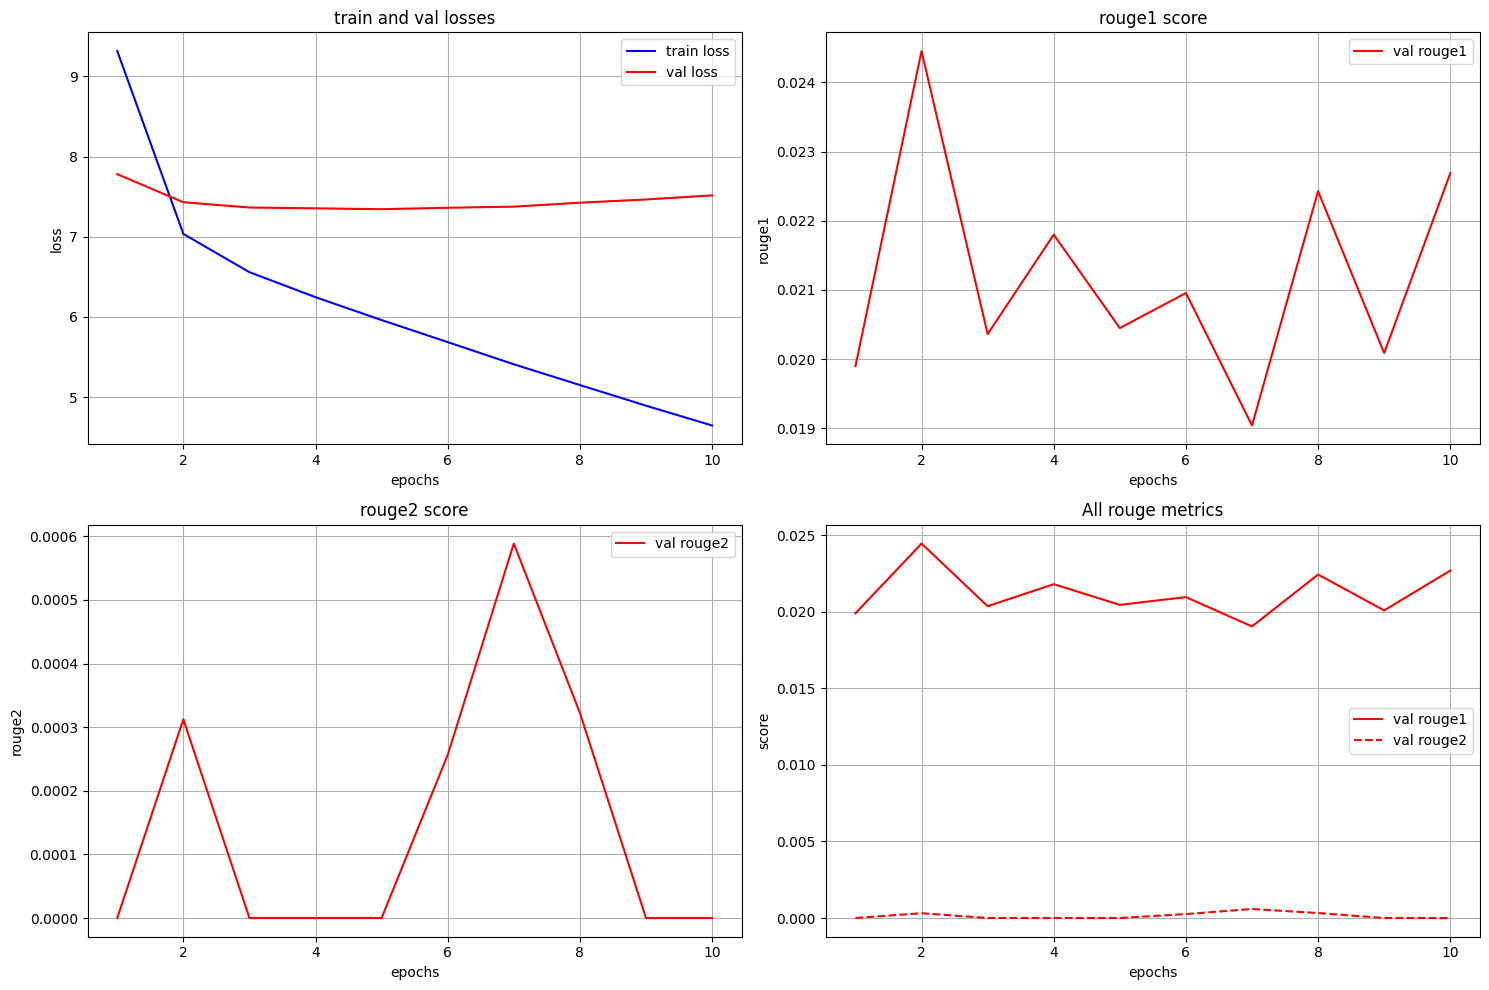

In [10]:
train_model(
    model,
    tokenizer,
    config,
    train_dataloader,
    val_dataloader,
    val_sample_dataloader,
    criterion,
    optimizer,
)

### Сохранение модели

In [11]:
torch.save({
        'model_state_dict': model.state_dict(),
        'config': config,
    }, config.model_path
    )

### Загрузка модели

In [12]:
add_safe_globals([Config])
checkpoint = torch.load(config.model_path, map_location=config.device)
model = LSTMModel(checkpoint["config"]).to(config.device)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

LSTMModel(
  (embedding): Embedding(50257, 256, padding_idx=50256)
  (lstm): LSTM(256, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=50257, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### Генерация дополнения текстов

In [13]:
samples = random.sample(test_texts, 6) # 6 примеров
generate_samples(model, tokenizer, config, samples)

asis:       hahaha suriously feel like everyone knows this show is  ->  a joke except lc
generated:  hahaha suriously feel like everyone knows this show is  ->  n t have tot hurts by and0 my night so much a am fish he home is acting k t know hope it s going to get old got to hear that shopo more well others this sick in nd i haveittixel gone him
rouge1: 0.0417,   rouge2: 0.0000

asis:       ut all says not  ->  in stock
generated:  ut all says not  ->  end familyd keep s ally about for 3y a the moment ot on and the updates chat e of a hope can t leastet but i was music my braces days ts more just again red internet a you episodes just school k missed on editingin
rouge1: 0.0000,   rouge2: 0.0000

asis:       but this is canada canada is weird we re supposed to get  ->  snow through wednesday ugh
generated:  but this is canada canada is weird we re supposed to get  ->   sc behaved time to ever until but it hate it s a picture i sleeping and hyisa could still no one the forgotten got one

### Метрики rouge модели на тестовой выборке

In [14]:
print('----модель lstm---------')
print('\nколичество параметров: ', f"{count_parameters(model):_}")
print('\nтекстов в выборке: ', f"{len(test_texts):_}", '\n')

test_dataloader = DataLoader(test_dataset, **dl_config, shuffle=False)

r1, r2 = calculate_rouge_lstm(
    model, test_dataloader, tokenizer, config, prefix="test"
)
print(f"\ntest rouge1: {r1:.4f}, test rouge2: {r2:.4f}")
print('-'*40)

----модель lstm---------

количество параметров:  19_546_577

текстов в выборке:  98 



         сalc rouge metrics test: 100%|██████████| 7/7 [00:02<00:00,  2.64it/s, rouge1 max=0.1765]


test rouge1: 0.0245, test rouge2: 0.0000
----------------------------------------


# Сравнение с трансформером и выводы

### Метрики rouge трансформера на тестовой выборке

In [16]:
print('----модель distilgpt2---------')

tokenizer.padding_side = "left"
generator = pipeline("text-generation", model="distilgpt2", device=config.device, batch_size=config.batch_size, truncation=True, tokenizer=tokenizer)

print('\nколичество параметров: ', f"{count_parameters(generator.model):_}")
print('\nтекстов в выборке: ', f"{len(test_texts):_}", '\n')

r1,r2 = calculate_rouge_transformer(generator, config, test_texts)

print(f"\ntest rouge1: {r1:.4f}, test rouge2: {r2:.4f}")
print('-'*40)

----модель distilgpt2---------


Device set to use cuda



количество параметров:  81_912_576

текстов в выборке:  98 



         сalc rouge metrics test: 98it [00:00, 1068.77it/s, rouge1 max=0.4000]


test rouge1: 0.0246, test rouge2: 0.0015
----------------------------------------
